## The power of sHG1G2

let's take objects with oblateness and a lot of observations


In [1]:
from fink_utils.sso.periods import estimate_synodic_period # v0.21.0 or more
import requests
import time
import io

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

### BFT

In [2]:
bft_source = "local" # choose `net` to download it

cols = [
    'sso_number', 'sso_name', 'sso_class',
    'spins.1.period.value', 'spins.2.period.value',
]

if bft_source == "local":
    # Local Configuration
    bft_file = '/tmp/ssoBFT-latest.parquet' 
    bft = pd.read_parquet(bft_file, columns=cols)
elif bft_source == 'net':
    r = requests.get("https://ssp.imcce.fr/data/ssoBFT-latest_Asteroid.parquet")
    bft = pd.read_parquet(io.BytesIO(r.content), columns=cols)
    bft.to_parquet("/tmp/ssoBFT-latest.parquet")

### SSOFT

In [3]:
r = requests.post(
  "https://fink-portal.org/api/v1/ssoft",
  json={
    "flavor": "SHG1G2",
    "version": "2024.08",
    "output-format": "parquet"
  }
)

# Format output in a DataFrame
ssoft = pd.read_parquet(io.BytesIO(r.content))

In [4]:
# Keep oblate ones
c0 = ssoft["R"] > 0.5
c1 = ssoft["R"] < 0.7
ssoft_oblate = ssoft[c0 & c1]

# Keep only known periods
data = ssoft_oblate.merge(bft, left_on="sso_name", right_on="sso_name", how="left")
data = data[data["spins.1.period.value"] == data["spins.1.period.value"]]

# sort by number of observations
data = data.sort_values("n_obs", ascending=False)

data[["sso_number_x", "sso_name", "R", "n_obs", "n_obs_1", "n_obs_2", "sso_class", "spins.1.period.value", "spins.2.period.value"]]

,sso_number_x,sso_name,R,n_obs,n_obs_1,n_obs_2,sso_class,spins.1.period.value,spins.2.period.value
5736,20729.0,1999 XS143,0.534847,504.0,195.0,309.0,Trojan>L4,5.72000,7.6310
7273,22149.0,2000 WD49,0.647774,497.0,193.0,304.0,Trojan>L4,6.75170,NaN
4887,1437.0,Diomedes,0.605492,490.0,182.0,308.0,Trojan>L4,24.49800,24.5010
7993,911.0,Agamemnon,0.628098,469.0,183.0,286.0,Trojan>L4,6.58178,6.5818
21486,2363.0,Cebriones,0.652312,452.0,194.0,258.0,Trojan>L5,20.07640,NaN
...,...,...,...,...,...,...,...,...,...
20305,36171.0,1999 RM242,0.685775,50.0,23.0,27.0,MB>Outer,79.98000,79.9800
5679,147366.0,2003 CZ18,0.694734,50.0,19.0,31.0,MB>Middle,6.52018,58.5957
11527,322777.0,2001 KL43,0.575240,50.0,20.0,30.0,MB>Outer,46.89300,NaN
27512,118239.0,1997 KX,0.669006,50.0,17.0,33.0,MB>Outer,4.64200,NaN


In [5]:
from fink_utils.sso.periods import estimate_synodic_period

ssnamenr_2 = 20729

period_shg1g2, chi2red_shg1g2, frequency_shg1g2, power_shg1g2, model_shg1g2, pdf_shg1g2 = estimate_synodic_period(
    ssnamenr=ssnamenr_2, flavor="SHG1G2", Nterms_base=2, period_range=(1./24, 10), return_extra_info=True
)

period_hg, chi2red_hg, frequency_hg, power_hg, model_hg, pdf_hg = estimate_synodic_period(
    ssnamenr=ssnamenr_2, flavor="HG12", Nterms_base=2, period_range=(1./24, 10), return_extra_info=True
)

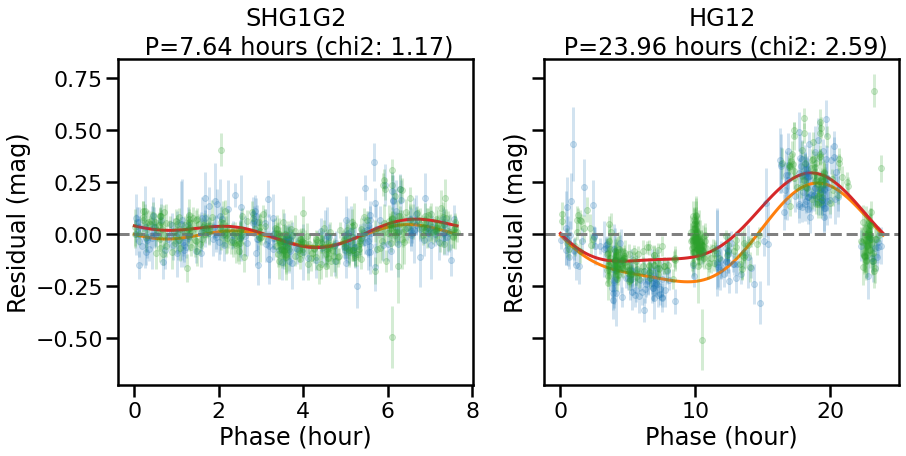

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

flavors = ["SHG1G2", "HG12"]
for flavor, period_, model_, pdf_, chi2red_ in zip(flavors, [period_shg1g2, period_hg], [model_shg1g2, model_hg], [pdf_shg1g2, pdf_hg], [chi2red_shg1g2, chi2red_hg]):
    tfit = np.linspace(0, period_/24, 100)
    magfit = model_.model(tfit, 1/period_*24)
    for filtnum in pdf_["i:fid"].unique():
        cond = pdf_['i:fid'] == filtnum    
        phase = pdf_["i:jd"][cond] % (period_/24)
        ax[flavors.index(flavor)].errorbar(phase * 24, pdf_["residuals"][cond], pdf_['i:sigmapsf'][cond], ls="", marker='.', alpha=0.2)
        ax[flavors.index(flavor)].plot(tfit * 24, magfit[filtnum - 1], ls="-", marker='')
    ax[flavors.index(flavor)].axhline(0, ls="--", color="grey")
    # plt.ylim(-0.7, 0.7)
    ax[flavors.index(flavor)].set_title("{}\n P={:.2f} hours (chi2: {:.2f})".format(
        flavor, period_, chi2red_))
    ax[flavors.index(flavor)].set_xlabel("Phase (hour)")
    ax[flavors.index(flavor)].set_ylabel("Residual (mag)")